#Packages/Installations

In [1]:
!pip3 install nest_asyncio
!python3 -m pip install pystan
!python -m pip install Cython
!pip install nfl_data_py

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import nfl_data_py as nfl
import nest_asyncio
import stan

#Best Ball Mania Data

In [16]:
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/bbm_data.csv'
data = pd.read_csv(file_path, index_col=[0])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
data = data[['draft_id', 'player_name', 'position_name', 'position_pick_number', 'year']]
data

,draft_id,player_name,position_name,position_pick_number,year
0,65219f4a-267e-4035-806a-646a3c1a846e,Stefon Diggs,WR,4,2023
1,65219f4a-267e-4035-806a-646a3c1a846e,Josh Allen,QB,1,2023
2,65219f4a-267e-4035-806a-646a3c1a846e,Keenan Allen,WR,16,2023
3,65219f4a-267e-4035-806a-646a3c1a846e,Christian Watson,WR,23,2023
4,65219f4a-267e-4035-806a-646a3c1a846e,T.J. Hockenson,TE,3,2023
...,...,...,...,...,...
22434313,ffff3a71-d0bb-491d-bce0-635aa2242d9f,Kareem Hunt,RB,25,2021
22434314,ffff3a71-d0bb-491d-bce0-635aa2242d9f,Amari Cooper,WR,11,2021
22434315,ffff3a71-d0bb-491d-bce0-635aa2242d9f,Austin Hooper,TE,24,2021
22434316,ffff3a71-d0bb-491d-bce0-635aa2242d9f,D.J. Chark,WR,34,2021


#Fantasy Points Data (NFL Data Py)

In [18]:
print([i for i in nfl.see_pbp_cols()])

['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result', 'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout', 'timeout_team', 'td_team', 'td_player_name', 'td_player_id', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'total_home_score', 'total_away_score', 'posteam_score', 'defteam_score', 'score_differential', 'posteam_score_post', 'defteam_score_post', 'score_differential

In [19]:
nfl_data = nfl.import_weekly_data([2021, 2022, 2023], columns = ['player_display_name', 'position', 'season', 'week', 'fantasy_points', 'fantasy_points_ppr'])
nfl_data['fantasy_points_half_ppr'] = ((nfl_data['fantasy_points'] + nfl_data['fantasy_points_ppr']) / 2)
nfl_data['fantasy_points_half_ppr'] = nfl_data['fantasy_points_half_ppr']
nfl_data.drop(columns=['fantasy_points', 'fantasy_points_ppr'], inplace=True)
nfl_data

Downcasting floats.


,player_display_name,position,season,week,fantasy_points_half_ppr
0,Tom Brady,QB,2021,1,27.160000
1,Tom Brady,QB,2021,2,29.639999
2,Tom Brady,QB,2021,3,28.680000
3,Tom Brady,QB,2021,4,11.060000
4,Tom Brady,QB,2021,5,37.740002
...,...,...,...,...,...
5648,Zach Charbonnet,RB,2023,14,5.300000
5649,Zach Charbonnet,RB,2023,15,1.600000
5650,Zach Charbonnet,RB,2023,16,0.100000
5651,Zach Charbonnet,RB,2023,17,6.600000


#Fitting STAN Model

In [ ]:
nest_asyncio.apply()

In [ ]:
mean_fantasy_points_by_year = nfl_data.groupby(['player_display_name', 'season'])['fantasy_points_half_ppr'].mean().reset_index()
mean_position_pick_number_by_year = data.groupby(['player_name', 'year', 'position_name'])['position_pick_number'].mean().reset_index()

merged_data_by_year = mean_fantasy_points_by_year.merge(
    mean_position_pick_number_by_year,
    left_on=['player_display_name', 'season'],
    right_on=['player_name', 'year'],
    how='inner'
).drop(columns=['player_name', 'season'])

In [ ]:
merged_data_by_year

,player_display_name,season,fantasy_points_half_ppr,position_name,position_pick_number,week
0,A.J. Brown,2021,12.292857,WR,6.687597,1
1,A.J. Brown,2021,12.292857,WR,6.687597,2
2,A.J. Brown,2021,12.292857,WR,6.687597,3
3,A.J. Brown,2021,12.292857,WR,6.687597,5
4,A.J. Brown,2021,12.292857,WR,6.687597,6
...,...,...,...,...,...,...
14825,Zonovan Knight,2022,7.500000,RB,58.250000,16
14826,Zonovan Knight,2022,7.500000,RB,58.250000,17
14827,Zonovan Knight,2022,7.500000,RB,58.250000,18
14828,Zonovan Knight,2023,1.300000,RB,62.736264,3


In [ ]:
mean_fantasy_points_by_year

,player_display_name,season,fantasy_points_half_ppr
0,A.J. Brown,2021,12.292857
1,A.J. Brown,2022,14.135000
2,A.J. Brown,2023,13.917647
3,A.J. Dillon,2021,9.838888
4,A.J. Dillon,2022,9.035295
...,...,...,...
1867,Zay Jones,2021,6.062500
1868,Zay Jones,2022,10.294445
1869,Zay Jones,2023,6.788889
1870,Zonovan Knight,2022,7.500000


In [ ]:
merged_data_by_year

,player_display_name,fantasy_points_half_ppr,year,position_name,position_pick_number
0,A.J. Brown,12.292857,2021,WR,6.687597
1,A.J. Brown,14.135000,2022,WR,10.732179
2,A.J. Brown,13.917647,2023,WR,6.100004
3,A.J. Green,7.635294,2021,WR,75.090923
4,A.J. Green,3.815384,2022,WR,83.498659
...,...,...,...,...,...
1384,Zay Jones,6.062500,2021,WR,96.500000
1385,Zay Jones,10.294445,2022,WR,82.752882
1386,Zay Jones,6.788889,2023,WR,56.383503
1387,Zonovan Knight,7.500000,2022,RB,58.250000


In [ ]:
df_wr = merged_data_by_year[merged_data_by_year['position_name'] == 'WR']

stan_data = {
    'N': len(df_wr),
    'position_pick_number': df_wr['position_pick_number'].values,
    'fantasy_points_half_ppr': df_wr['fantasy_points_half_ppr'].values
}

In [ ]:
stan_code = """
data {
  int<lower=0> N; // Number of data points
  vector[N] position_pick_number; // Predictor
  vector[N] fantasy_points_half_ppr; // Response
}

parameters {
  real alpha; // Intercept
  real beta1; // Linear term
  real beta2; // Quadratic term
  real<lower=0> sigma; // Standard deviation of the residuals
}

model {
  // Priors
  alpha ~ normal(0, 10);
  beta1 ~ normal(0, 10);
  beta2 ~ normal(0, 10);
  sigma ~ normal(0, 5);

  // Likelihood
  fantasy_points_half_ppr ~ normal(alpha + beta1 * position_pick_number + beta2 * square(position_pick_number), sigma);
}
"""

# Compile the model
model = stan.build(stan_code, data=stan_data)

# Sample from the posterior
fit = model.sample(num_chains=4, num_samples=1000)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   5% (400/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1601/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2401/8000)
Sampling:  31% (2501/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Sampling:  44% (3500/8000)
Sampling:  45% (3600/8000)
Sampling:  46% (3700/8000)
Sampling:  46% (3701/8000)
Sampling:  48% (3801/8000)
Sampling:  49% (3900/8000)
Sampling:  50

In [ ]:
fit_df = fit.to_frame()
print(fit_df.describe())

parameters         lp__  accept_stat__   stepsize__  treedepth__  \
count       4000.000000    4000.000000  4000.000000  4000.000000   
mean        -824.454560       0.894317     0.006835     6.759250   
std            5.190130       0.146588     0.000615     1.753157   
min         -931.397425       0.000863     0.005868     1.000000   
25%         -824.940625       0.855765     0.006604     6.000000   
50%         -823.849216       0.956892     0.006955     7.000000   
75%         -823.080917       0.994079     0.007186     8.000000   
max         -822.155641       1.000000     0.007560    10.000000   

parameters  n_leapfrog__  divergent__     energy__        alpha        beta1  \
count        4000.000000       4000.0  4000.000000  4000.000000  4000.000000   
mean          239.864000          0.0   826.465025    14.798350    -0.176221   
std           197.514436          0.0     5.643405     0.662957     0.027560   
min             1.000000          0.0   822.375244     6.686111    

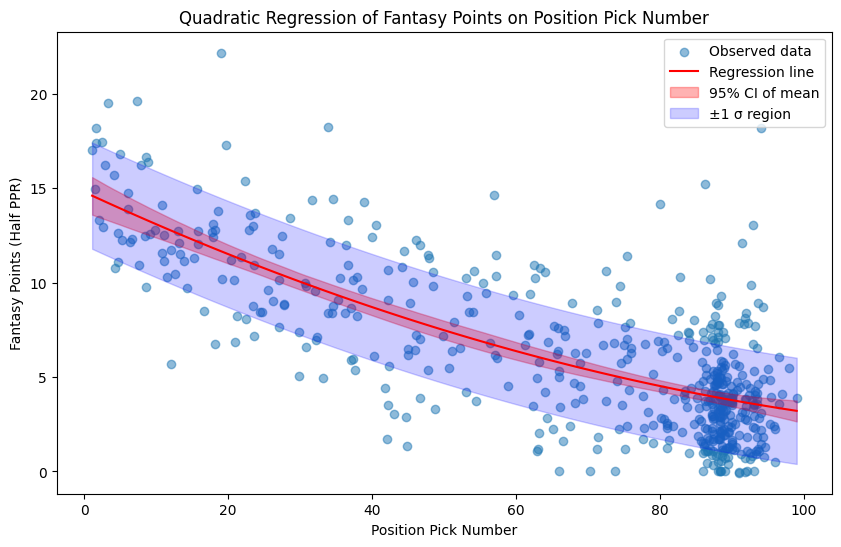

In [ ]:
alpha_samples = fit['alpha']
beta1_samples = fit['beta1']
beta2_samples = fit['beta2']
sigma_samples = fit['sigma']

x = np.linspace(min(stan_data['position_pick_number']), max(stan_data['position_pick_number']), 100)
y_mean = alpha_samples.mean() + beta1_samples.mean() * x + beta2_samples.mean() * np.square(x)

y_lower = np.percentile(alpha_samples + beta1_samples * x[:, None] + beta2_samples * np.square(x)[:, None], 2.5, axis=1)
y_upper = np.percentile(alpha_samples + beta1_samples * x[:, None] + beta2_samples * np.square(x)[:, None], 97.5, axis=1)

sigma_mean = sigma_samples.mean()
y_sigma_lower = y_mean - sigma_mean
y_sigma_upper = y_mean + sigma_mean

plt.figure(figsize=(10, 6))
plt.scatter(stan_data['position_pick_number'], stan_data['fantasy_points_half_ppr'], alpha=0.5, label='Observed data')
plt.plot(x, y_mean, color='red', label='Regression line')
plt.fill_between(x, y_lower, y_upper, color='red', alpha=0.3, label='95% CI of mean')
plt.fill_between(x, y_sigma_lower, y_sigma_upper, color='blue', alpha=0.2, label='±1 σ region')
plt.xlabel('Position Pick Number')
plt.ylabel('Fantasy Points (Half PPR)')
plt.title('Quadratic Regression of Fantasy Points on Position Pick Number')
plt.legend()
plt.show()

#Second Model

In [20]:
nest_asyncio.apply()
data['avg_draft_position'] = data.groupby(['year', 'player_name'])['position_pick_number'].transform('mean')
data = data[['player_name', 'position_name', 'year', 'avg_draft_position']].drop_duplicates()
merged_data = pd.merge(nfl_data, data, how='inner',
                       left_on=['player_display_name', 'position', 'season'],
                       right_on=['player_name', 'position_name', 'year'])

merged_data = merged_data[['player_display_name', 'position', 'season', 'week', 'fantasy_points_half_ppr', 'avg_draft_position']]

In [8]:
merged_data['player_year_id'] = pd.factorize(merged_data['player_display_name'].astype(str) + '_' + merged_data['season'].astype(str))[0] + 1  # Ensure 1-indexing for Stan

In [9]:
merged_data = merged_data[merged_data['position'] == 'WR']

In [21]:
merged_data

,player_display_name,position,season,week,fantasy_points_half_ppr,avg_draft_position
0,Tom Brady,QB,2021,1,27.160000,10.484708
1,Tom Brady,QB,2021,2,29.639999,10.484708
2,Tom Brady,QB,2021,3,28.680000,10.484708
3,Tom Brady,QB,2021,4,11.060000,10.484708
4,Tom Brady,QB,2021,5,37.740002,10.484708
...,...,...,...,...,...,...
14716,Zach Charbonnet,RB,2023,14,5.300000,34.151697
14717,Zach Charbonnet,RB,2023,15,1.600000,34.151697
14718,Zach Charbonnet,RB,2023,16,0.100000,34.151697
14719,Zach Charbonnet,RB,2023,17,6.600000,34.151697


In [23]:
merged_data['player_year_id'] = merged_data.groupby(['player_display_name', 'season']).ngroup() + 1


In [14]:
merged_data

{'N': 6033,
 'P': 533,
 'player': array([120, 120, 120, ..., 264, 264, 264]),
 'fantasy_points': array([11.9      ,  1.4      ,  3.1999998, ..., 13.2      ,  0.       ,
         6.3999996], dtype=float32),
 'avg_draft_position': array([88.        , 88.        , 88.        , ..., 72.50459909,
        72.50459909, 72.50459909])}

In [24]:
merged_data = {
    'N': len(merged_data),
    'P': len(merged_data['player_year_id'].unique()),
    'player': merged_data['player_year_id'].values,
    'fantasy_points': merged_data['fantasy_points_half_ppr'].values,
    'avg_draft_position': merged_data['avg_draft_position'].values
}

In [25]:
stan_model_code = """
data {
  int<lower=0> N;  // number of observations
  int<lower=0> P;  // number of players
  array[N] int<lower=1, upper=P> player;  // player index
  vector[N] fantasy_points;  // observed fantasy points
  vector[N] avg_draft_position;  // average draft position
}

parameters {
  vector[P] mu_player;  // player-specific mean
  real alpha;  // intercept for the mu model
  real beta;  // coefficient for avg_draft_position in the mu model
  real<lower=0> sigma_mu;  // standard deviation of player means
  real<lower=0> sigma;  // base standard deviation of observations
  real<lower=0> sigma_beta;  // slope of variance with respect to player mean
}

model {
  vector[N] mu;
  vector[N] variance;

  // Priors
  mu_player ~ normal(0, sigma_mu);
  alpha ~ normal(0, 10);
  beta ~ normal(0, 10);
  sigma ~ normal(0, 10);
  sigma_beta ~ normal(0, 5);

  for (n in 1:N) {
    mu[n] = alpha + beta * avg_draft_position[n];
    variance[n] = square(sigma) + square(sigma_beta) * square(mu_player[player[n]]);
    fantasy_points[n] ~ normal(mu_player[player[n]], sqrt(variance[n]));
  }
}
"""

In [ ]:
import stan

# Build the Stan model
posterior = stan.build(stan_model_code, data=merged_data)

# Sample from the posterior
fit = posterior.sample(num_chains=4, num_samples=2000, num_warmup=1000)

# Print summary
print(fit)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=RuntimeError("connect: Connection refused [system:111 at httpstan/include/boost/asio/detail/reactive_socket_service.hpp:587 in function 'connect']")>
concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.10/concurrent/futures/process.py", line 246, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/usr/local/lib/python3.10/dist-packages/httpstan/services_stub.py", line 47, in _make_lazy_function_wrapper_helper
    return function(*args, **kwargs)  # type: ignore
RuntimeError: connect: Connection refused [system:111 at httpstan/include/boost/asio/detail/reactive_socket_service.hpp:587 in function 'connect']
"""

The above exception was the 